## Self-supervised learning by predicting image rotations

[Diego Ortego](https://sites.google.com/view/diegoortego/), [Insight Centre for Data Analytics](https://www.insight-centre.org/)

[Dublin City University](https://www.dcu.ie/)

---

This lab will illustrate how to specify and train [RotNet](https://arxiv.org/abs/1803.07728), a pretext task for self-supervised learning that rotates the image by 0, 90, 180 or 270 degrees (i.e. 4 classes) and learns to predict one of the four classes (rotations) for each image. The assumption behind the formation of useful features: learning to predict the rotation of an image involves that the network has to locate the object in the image and partially understand its shape and components.
Obviously, one reason for this method to work is that objects tend to appear with no rotations in the image. Note that this might not be always true and that some objects are not sensitive to rotations (e.g. a ball). Some works have shown that discarding these kind of samples helps on improving representation learning.

## Instructions

Anywhere you see a **???** in the code below, fill in in with the correct code. Also, respond the question included in the Section "k-Nearest Neighbour (kNN) search"

In [ ]:
import sys
print(sys.version)

3.7.13 (default, Mar 16 2022, 17:37:17) 
[GCC 7.5.0]


# Import packages
Find the PyTorch docs at https://pytorch.org/docs/stable/index.html

Tutorials: https://pytorch.org/tutorials/

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.backends.cudnn as cudnn
import torch.utils.data as data
from torch import optim
from torchvision import datasets, transforms, models
import torch.nn.functional as F
from torch.utils.data import Dataset
from torchvision.datasets.utils import download_file_from_google_drive



from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import random
import argparse
import os
import time
from os.path import join
import csv


print('PyTorch version:', torch.__version__)

PyTorch version: 1.10.0+cu111


# Download dataset


In [ ]:
!gdown --id 1CbAF-QhMzo01-iNV9OEQuQK_9u2OiMDt
#!gdown --id 1FnnokBqZR4ahasDUQzYYXGpTUZOlOsji

/usr/local/lib/python3.7/dist-packages/gdown/cli.py:131: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  category=FutureWarning,
Downloading...
From: https://drive.google.com/uc?id=1CbAF-QhMzo01-iNV9OEQuQK_9u2OiMDt
To: /content/miniImagenet84.tar
100% 352M/352M [00:02<00:00, 130MB/s]


In [ ]:
!tar xf miniImagenet84.tar

In [ ]:
!rm miniImagenet84.tar

# Hyperparameters + Enable GPU acceleration

In [ ]:
class configuration:
  def __init__(self):
    self.experiment_name = "prueba_ResNet14_7x7"
    self.pre_load = "True"
    self.num_classes = 4
    self.lr = 0.1 #learning rate
    self.M = [55, 65]
    self.batch_size = 100 #Training batch size
    self.test_batch_size = 100 #Test batch size
    self.epoch = 70
    self.train_root = "./miniImagenet84"
    self.download = False
    self.seed = 271828

## Create arguments object
args = configuration()

# Make sure to enable GPU acceleration!
device = 'cuda'

# Set random seed for reproducability
torch.backends.cudnn.deterministic = True  # fix the GPU to deterministic mode
torch.manual_seed(args.seed)  # CPU seed
torch.cuda.manual_seed_all(args.seed)  # GPU seed
random.seed(args.seed)  # python seed for image transformation
np.random.seed(args.seed)

## Define CNN architecture
We are using a small and slightly modified ResNet

In [ ]:
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion*planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion*planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion*planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=4):
        super(ResNet, self).__init__()
        self.in_planes = 64

        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)
        self.linear = nn.Linear(512*block.expansion, num_classes)
        

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = out.view(out.size(0), -1)
        #### To fill: add forward pass of the linear layer
        out = self.linear(out)

        return out

    def forwardFeatures(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = F.adaptive_avg_pool2d(out, (1, 1))
        out = out.view(out.size(0), -1)

        return out


## Define dataset class
Dataset: subset of ImageNet with 25K (5K for validation) images and 64x64 resolution. **We do not use the labels.**

Methods to make the dataset and rotate images are also included

In [ ]:
def rotate_img(img, rot):
    if rot == 0:  # 0 degrees rotation
        return img
    elif rot == 90:  # 90 degrees rotation
        return np.flipud(np.transpose(img, (1, 0, 2)))
    elif rot == 180:  # 90 degrees rotation
        return np.fliplr(np.flipud(img))
    elif rot == 270:  # 270 degrees rotation / or -90
        return np.transpose(np.flipud(img), (1, 0, 2))
    else:
        raise ValueError('rotation should be 0, 90, 180, or 270 degrees')


def make_dataset(args):
    np.random.seed(42)
    csv_files = ["train.csv", "val.csv", "test.csv"]
    img_paths = []
    labels = []
    for split in csv_files:
        in_csv_path = join(args.train_root, split)
        in_images_path = join(args.train_root, "images")

        with open(in_csv_path) as csvfile:
            csvreader = csv.reader(csvfile, delimiter=',')
            next(csvreader, None)
            for i,row in enumerate(csvreader):
                img_paths.append(join(in_images_path,row[0]))
                labels.append(row[1])

    mapping = {y: x for x, y in enumerate(np.unique(labels))}
    label_mapped = [mapping[i] for i in labels]

    # labels

    # split in train and validation:
    train_num = 50000
    val_num = 10000

    idxes = np.random.permutation(len(img_paths))

    img_paths = np.asarray(img_paths)[idxes]
    label_mapped = np.asarray(label_mapped)[idxes]

    train_img_paths = img_paths[:train_num]
    train_labels = label_mapped[:train_num]
    val_img_paths = img_paths[train_num:]
    val_labels = label_mapped[train_num:]

    ###Smaller dataset

    train_img_paths = train_img_paths[:25000]
    train_labels = train_labels[:25000]
    val_img_paths = val_img_paths[:5000]
    val_labels = val_labels[:5000]


    if args.pre_load == "True":
        train_pil_images = []
        print("Loading Images in memory...")
        
        for i in train_img_paths:
            train_pil_images.append(np.asarray(Image.open(i)))
        train_data = np.asarray(train_pil_images)

        val_pil_images = []
        for i in val_img_paths:
            val_pil_images.append(np.asarray(Image.open(i)))
        val_data = np.asarray(val_pil_images)
    else:
        train_data = train_img_paths
        val_data = val_img_paths

    return train_data, train_labels, val_data, val_labels

class MiniImagenet84(Dataset):
    
    def __init__(self, args, data, labels, train=True, transform_pre=None, transform_pre_test=None, transform=None, target_transform=None):

        self.args = args
        self.data, self.labels = data, labels
        self.transform_pre = transform_pre
        self.transform_pre_test = transform_pre_test
        self.transform = transform
        self.target_transform = target_transform
        self.train = train

    ##getitem method is always defined in the dataset class to define the operations
    ##to do to load 1 image of a mini-batch. For example, all the data transformations.
    def __getitem__(self, index): 
        ## Get path of image to load and associated label
        img, labels = self.data[index], self.labels[index]

        ## Load image
        if self.args.pre_load == "True":
            img = Image.fromarray(img)
        else:
            img = Image.open(img)
        
        ## Data transformations (data augmentation)
        if self.transform_pre is not None and self.train == True:
            img = self.transform_pre(img)
        elif self.train == False:
            img = self.transform_pre_test(img)

        ## List of 4 images, each with a different rotation
        rotated_imgs = [
            self.transform(img), ## 0 degrees rotation
            self.transform(rotate_img(img,90).copy()), ## 90 degrees rotation
            self.transform(rotate_img(img,180).copy()), ## 180 degrees rotation
            self.transform(rotate_img(img,270).copy()) ## 270 degrees rotation
        ]
        ## Createe rotation labels, i.e. 4 (0-3)
        rot_labels = torch.LongTensor([0, 1, 2, 3])
        ## Stack the list of rotated images into a tensor
        rot_img = torch.stack(rotated_imgs, dim=0)
        ## Data transformations to tensor and normalization
        img = self.transform(img)

        return rot_img, rot_labels, img, labels, index


    def __len__(self):
        return len(self.data)

# RotNet training epoch
It is a simple multi-class classification problem

In [ ]:
def train_RotNet(args, model, device, train_loader, optimizer, epoch):

    train_loss = []
    # switch to train mode
    model.train()
    loss_per_batch = []
    acc_per_batch = []

    counter = 1
    correct = 0

    #### To fill: define a cross-entropy loss criterion. Use a function that directly computes the log_softmax.
    criterion = nn.CrossEntropyLoss()

    for batch_idx, (images, labels, _, _, _) in enumerate(train_loader):

        images, labels = images.to(device), labels.to(device)
        size = images.size()
        images = images.view(-1, size[2], size[3], size[4])
        labels = labels.view(-1)

        #### To fill: do forward pass
       # outputs= model.forwardFeatures(images)

        outputs = model(images)

        ## Cross-entropy loss with soft labels

        #### To fill: compute cross-entropy loss using the criterion defined above
        loss = criterion(outputs, labels)

        train_loss.append(loss.item())

        preds = outputs.max(1, keepdim=True)[1]  # get the index of the max log-probability
        correct += preds.eq(labels.view_as(preds)).sum().item()
        if images.size(0) < args.batch_size:
          acc_per_batch.append(100. * correct / (4*batch_idx*args.batch_size + images.size(0)))
        else:
          acc_per_batch.append(100. * correct / ((batch_idx + 1) * 4*args.batch_size))
        

        # compute gradient and do SGD step
        optimizer.zero_grad()


        #### To fill: perform backpropagation
        loss.backward()

        #### To fill: perfor a gradient descend step
        optimizer.step()

        if counter % 15 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}, Accuracy: {:.0f}%, Learning rate: {:.6f}'.format(
                epoch, int(counter * len(images)/4), len(train_loader.dataset),
                       100. * counter / len(train_loader), loss.item(),
                       acc_per_batch[-1], optimizer.param_groups[0]['lr']))
        counter = counter + 1

    return sum(train_loss)/len(train_loss), acc_per_batch[-1]

## RotNet validation
We compute the rotation accuracy. It has shown to translate reasonably well to quality of the representations (at least if the network is deep enough and enough data is used).

In [ ]:
def testing(args, model, device, test_loader):
    model.eval()
    loss_per_batch = []
    acc_val_per_batch =[]
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for batch_idx, (data, target, _, _, _) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            size = data.size()
            data = data.view(-1, size[2], size[3], size[4])
            target = target.view(-1)
            output = model(data)
            output = F.log_softmax(output, dim=1)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            loss_per_batch.append(F.nll_loss(output, target).item())
            pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            acc_val_per_batch.append(100. * correct / ((batch_idx+1)*4*args.test_batch_size))

    test_loss /= len(test_loader.dataset)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, 4*len(test_loader.dataset),
        100. * correct / (4*len(test_loader.dataset))))

    loss_per_epoch = [np.average(loss_per_batch)]
    acc_val_per_epoch = [np.array(100. * correct / (4*len(test_loader.dataset)))]

    return (loss_per_epoch, acc_val_per_epoch)

# Image transformations

In [ ]:
mean = [0.4728, 0.4487, 0.4031]
std = [0.2744, 0.2663 , 0.2806]

# ## Transformations for training data
transform_pre = transforms.Compose([
    transforms.Pad(6, padding_mode='reflect'),
    transforms.RandomCrop(64),
])

transform_pre_test = transforms.CenterCrop(64)

transform_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

## Transformations for test data
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

# Dataset, network, optimizer and scheduler creation

In [ ]:
# Create dataset
# prepare datasets
train_data, train_labels, val_data, val_labels = make_dataset(args)

trainset = MiniImagenet84(args, train_data, train_labels, train=True, transform_pre=transform_pre, transform=transform_train)

train_loader = torch.utils.data.DataLoader(trainset, batch_size=args.batch_size, shuffle=True, num_workers=8, pin_memory=True)
testset = MiniImagenet84(args, val_data, val_labels, train=False, transform_pre_test=transform_pre_test, transform=transform_test)
test_loader = torch.utils.data.DataLoader(testset, batch_size=args.test_batch_size, shuffle=False, num_workers=8, pin_memory=True)

print('-------> Data loading')

model = ResNet(BasicBlock, [2, 1, 2, 1], args.num_classes).to(device) ##ResNet-14
#model = ResNet(BasicBlock, [2, 2, 2, 2], args.num_classes).to(device) ##ResNet-18

print('Total params: %2.fM' % (sum(p.numel() for p in model.parameters()) / 1000000.0))

milestones = args.M
optimizer = optim.SGD(model.parameters(), lr=args.lr, momentum=0.9, weight_decay=1e-4)
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=0.1)



Loading Images in memory...


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


-------> Data loading
Total params:  6M


# Training loop

In [ ]:
loss_train_epoch = []
loss_test_epoch = []
acc_train_per_epoch = []
acc_test_per_epoch = []
new_labels = []

cont = 0

res_path = "./metrics_" + args.experiment_name

if not os.path.isdir(res_path):
    os.makedirs(res_path)

for epoch in range(1, args.epoch + 1):
    st = time.time()
    scheduler.step()
    # train for one epoch
    print("Self-supervised Learning (RotNet), epoch " + str(epoch))

    loss_per_epoch, top1_train_ac = train_RotNet(args, model, device, train_loader, optimizer, epoch)

    loss_train_epoch += [loss_per_epoch]

    # test
    loss_per_epoch_test, acc_val_per_epoch_i = testing(args, model, device, test_loader)

    loss_test_epoch += loss_per_epoch_test
    acc_train_per_epoch += [top1_train_ac]
    acc_test_per_epoch += acc_val_per_epoch_i


    if epoch == 1:
        best_acc_val = acc_val_per_epoch_i[-1]
        
    else:
        if acc_val_per_epoch_i[-1] > best_acc_val:
            best_acc_val = acc_val_per_epoch_i[-1]

    if epoch==args.epoch:
        torch.save(model.state_dict(), "myRotNetModelResNet14_7x7.pth")

    np.save(res_path + '/' + 'LOSS_epoch_train.npy', np.asarray(loss_train_epoch))
    np.save(res_path + '/' + 'LOSS_epoch_val.npy', np.asarray(loss_test_epoch))

    # save accuracies:
    np.save(res_path + '/' + 'accuracy_per_epoch_train.npy', np.asarray(acc_train_per_epoch))
    np.save(res_path + '/' + 'accuracy_per_epoch_val.npy', np.asarray(acc_test_per_epoch))

    cont += 1

Self-supervised Learning (RotNet), epoch 1


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_che

Train Epoch: 1 [1500/25000 (6%)]	Loss: 1.455082, Accuracy: 26%, Learning rate: 0.100000
Train Epoch: 1 [3000/25000 (12%)]	Loss: 1.388259, Accuracy: 26%, Learning rate: 0.100000
Train Epoch: 1 [4500/25000 (18%)]	Loss: 1.395409, Accuracy: 27%, Learning rate: 0.100000
Train Epoch: 1 [6000/25000 (24%)]	Loss: 1.358202, Accuracy: 28%, Learning rate: 0.100000
Train Epoch: 1 [7500/25000 (30%)]	Loss: 1.280594, Accuracy: 28%, Learning rate: 0.100000
Train Epoch: 1 [9000/25000 (36%)]	Loss: 1.330703, Accuracy: 29%, Learning rate: 0.100000
Train Epoch: 1 [10500/25000 (42%)]	Loss: 1.312476, Accuracy: 30%, Learning rate: 0.100000
Train Epoch: 1 [12000/25000 (48%)]	Loss: 1.323434, Accuracy: 30%, Learning rate: 0.100000
Train Epoch: 1 [13500/25000 (54%)]	Loss: 1.339921, Accuracy: 30%, Learning rate: 0.100000
Train Epoch: 1 [15000/25000 (60%)]	Loss: 1.294369, Accuracy: 31%, Learning rate: 0.100000
Train Epoch: 1 [16500/25000 (66%)]	Loss: 1.331222, Accuracy: 31%, Learning rate: 0.100000
Train Epoch: 1 [1

# Accuracy and loss curves

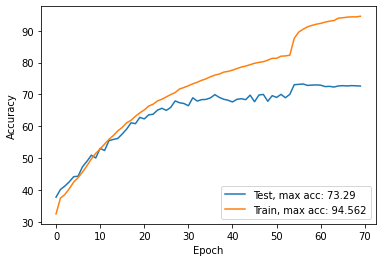

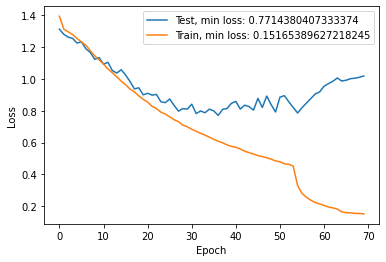

In [ ]:
##Accuracy
acc_train = np.load(res_path + '/' + 'accuracy_per_epoch_train.npy')
acc_test = np.load(res_path + '/' + 'accuracy_per_epoch_val.npy')

#Loss per epoch
loss_train = np.load(res_path + '/' + 'LOSS_epoch_train.npy')
loss_test = np.load(res_path + '/' + 'LOSS_epoch_val.npy')

numEpochs = len(acc_train)
epochs = range(numEpochs)

plt.figure(1)
plt.plot(epochs, acc_test, label='Test, max acc: ' + str(np.max(acc_test)))
plt.plot(epochs, acc_train, label='Train, max acc: ' + str(np.max(acc_train)))
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='lower right')

plt.figure(2)
plt.plot(epochs, loss_test, label='Test, min loss: ' + str(np.min(loss_test)))
plt.plot(epochs, loss_train, label='Train, min loss: ' + str(np.min(loss_train)))
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper right')

plt.show()

# Method to compute nearest neighbours (11 by default).

In [ ]:
def getKNN(args, model, device, test_loader, layer_features):

    # switch to val mode
    model.eval()
    if layer_features == 1:
        Features = torch.zeros([64, len(test_loader.dataset)], dtype=torch.float).to(device)##Layer 1
    elif layer_features == 2:
        Features = torch.zeros([128, len(test_loader.dataset)], dtype=torch.float).to(device)##Layer 2
    elif layer_features == 3:
        Features = torch.zeros([256, len(test_loader.dataset)], dtype=torch.float).to(device)##Layer 3
    elif layer_features == 4:
        Features = torch.zeros([512, len(test_loader.dataset)], dtype=torch.float).to(device)##Layer 4
    
    SimilarImages = torch.zeros([len(test_loader.dataset), 12], dtype=torch.long).to(device)

    print("Computing features...")

    for batch_idx, (_, _, images, labels, index) in enumerate(test_loader):
        batchSize = images.size(0)
        images, labels, index = images.to(device), labels.to(device), index.to(device)

        ##Forward pass
        outputs = model.forwardFeatures(images)

        if layer_features == 1:
            features = F.adaptive_avg_pool2d(activation['layer1'], (1, 1))
        elif layer_features == 2:
            features = F.adaptive_avg_pool2d(activation['layer2'], (1, 1))
        elif layer_features == 3:
            features = F.adaptive_avg_pool2d(activation['layer3'], (1, 1))
        elif layer_features == 4:
            features = F.adaptive_avg_pool2d(activation['layer4'], (1, 1))
     
        outputs = features.view(features.size(0), -1)

        ##L2-normalization of features
        outputs = F.normalize(outputs, p=2, dim=1)

        Features[:, index] = outputs.data.t()
    
    print("Finding similar images...")

    for batch_idx, (_, _, images, labels, index) in enumerate(test_loader):
        batchSize = images.size(0)
        images, labels, index = images.to(device), labels.to(device), index.to(device)

        ##Forward pass
        outputs = model.forwardFeatures(images)
        
        if layer_features == 1:
            features = F.adaptive_avg_pool2d(activation['layer1'], (1, 1))
        elif layer_features == 2:
            features = F.adaptive_avg_pool2d(activation['layer2'], (1, 1))
        elif layer_features == 3:
            features = F.adaptive_avg_pool2d(activation['layer3'], (1, 1))
        elif layer_features == 4:
            features = F.adaptive_avg_pool2d(activation['layer4'], (1, 1))

        outputs = features.view(features.size(0), -1)

        ##L2-normalization of features
        outputs = F.normalize(outputs, p=2, dim=1)

        ##Dot product of L2-normalized features (cosine similarity)
        #### To fill: dot product of current mini-batch L2-normalized features (from this loop) with all the L2-normalized feature vectors (previous loop)
        sim = torch.mm(outputs, Features)

        y_sim, y_idx = sim.topk(12, dim=1, largest=True, sorted=True)

        SimilarImages[index, :] = y_idx.data ##First column is just the query image

    return SimilarImages

# Visualizing 7x7x3 learnt filters in first layer

First layer 7x7 filters with RotNet initialyzed network


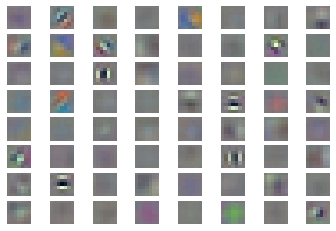

In [ ]:
##If you have trained the model, you should be able to load the weights by doing:
## (Loading is not needed as model variable contains the trained model)
model.load_state_dict(torch.load("myRotNetModelResNet14_7x7.pth"))


#### To fill: get first layer weights
kernels = model.conv1.weight.detach()

## Normalize weights
kernels = (kernels - kernels.min()) / (kernels.max() - kernels.min())

plt.figure(111)
print("First layer 7x7 filters with RotNet initialyzed network")
for i in range(0, 8):
    for j in range(0, 8):
        plt.subplot(8, 8, i*8 + j +1)
        plt.imshow(kernels[i*8 + j].squeeze().permute(1, 2, 0).cpu().numpy())
        plt.axis('off')

# k-Nearest Neighbour (kNN) search

Using the learnt features, it is possible to find similar images (better that a random initialization of the network).
Note that this is a toy example. Using a network with higher capacity and/or higher dimensional features can potentially lead to better results.

**QUESTION FOR STUDENTS**

Find 11-NN using features in layer `layer_features`

Play and inspect different layers. Usually, in supervised learning deeper features are closer to the class (output domain). You should observe that layer4, while being deeper, it provides worse neighbours than layer3. Why do you think this is?. NOTE: modify the variable `layer_features` to inspect neighboors with different features.

Response: I think it's because the layer 4 is much more dense than layer 3 and has more features in neighbourhood than layer 3, using KNN on layer 4 has more random neighbours than the neighbours in layer 3 and, maybe that is why layer 4 is giving not good results than layer3.

In [ ]:

## This is a hook to save intermidiate features while doing a forward pass
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()

    return hook


layer_features = 3 #4

if layer_features == 1:
  model.layer1.register_forward_hook(get_activation('layer1'))
elif layer_features == 2:
  model.layer2.register_forward_hook(get_activation('layer2'))
elif layer_features == 3:
  model.layer3.register_forward_hook(get_activation('layer3'))
elif layer_features == 4:
  model.layer4.register_forward_hook(get_activation('layer4'))


SimilarImages = getKNN(args, model, device, test_loader, layer_features)
SimilarImages = SimilarImages.cpu().numpy()


Computing features...


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Finding similar images...


Plot NN (one image per query)

Query 1


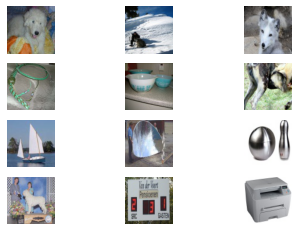

Query 2


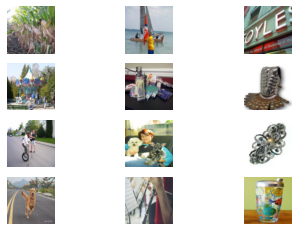

Query 3


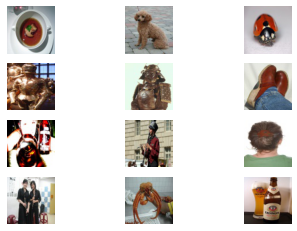

Query 4


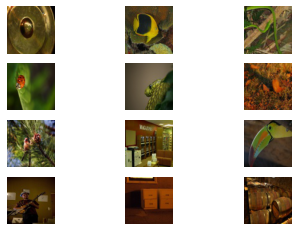

Query 5


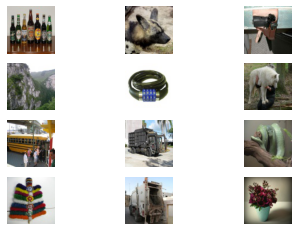

Query 6


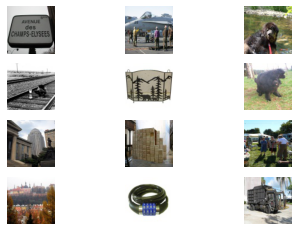

Query 7


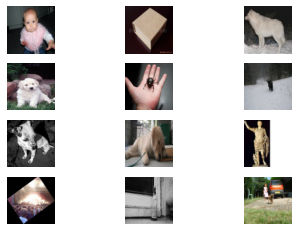

Query 8


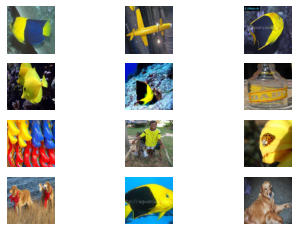

Query 9


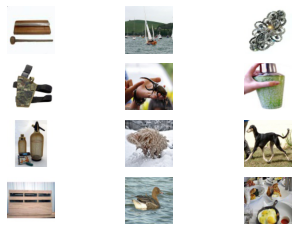

Query 10


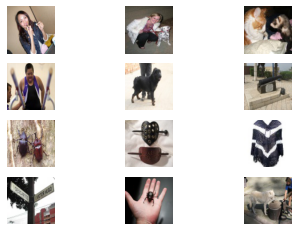

Query 11


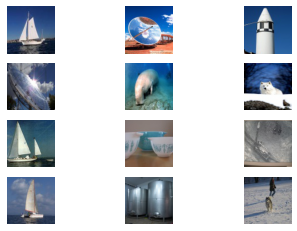

Query 12


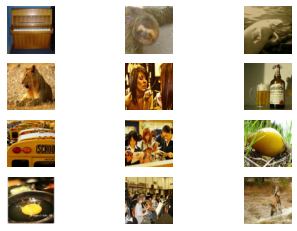

Query 13


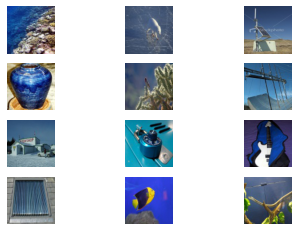

Query 14


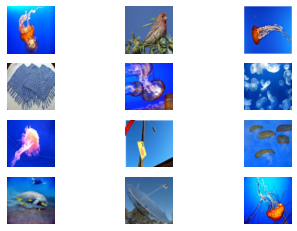

In [ ]:
examples_idx = [4, 15, 16, 49, 50, 53, 100, 101, 209, 2307, 2308, 3003, 3301, 3308]
## First image in the subplot is the query, we show 11 most similar images according to learnt features
for i in range(0, 14):
    plt.figure(i+1)
    
    for j in range(0, SimilarImages.shape[1]):
        plt.subplot(4, 3, j+1)
        plt.imshow(test_loader.dataset.data[SimilarImages[examples_idx[i], j], ...])
        plt.axis('off')
    print("Query " + str(i+1) )
    plt.show()
    
        

**Repeat the visualization of first layer filters and NN search with randomly initialized network**


Computing features...


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Finding similar images...
First layer 7x7 filters with randomly initialyzed network


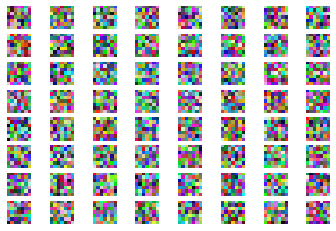

Query 1


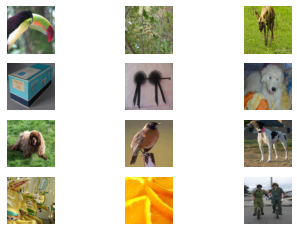

Query 2


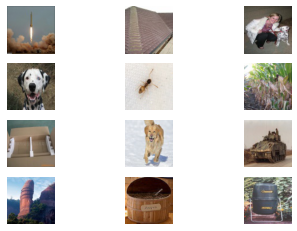

Query 3


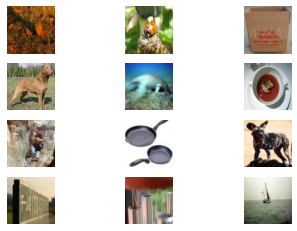

Query 4


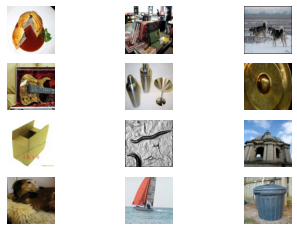

Query 5


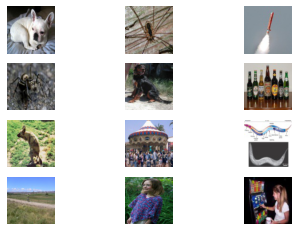

Query 6


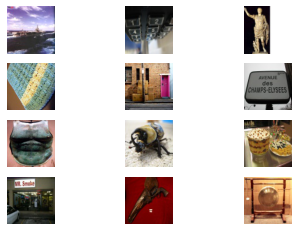

Query 7


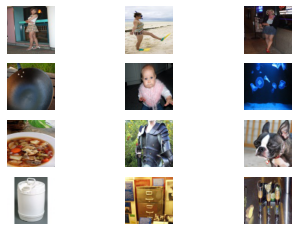

Query 8


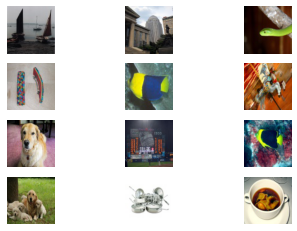

Query 9


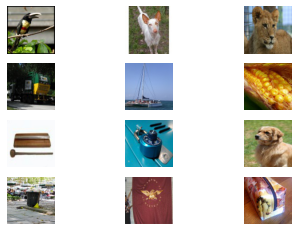

Query 10


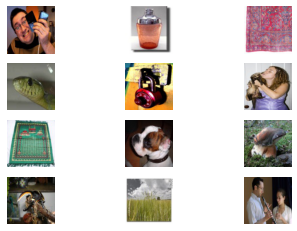

Query 11


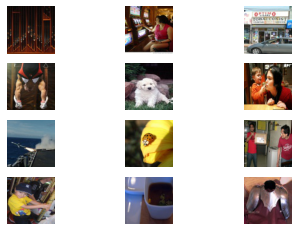

Query 12


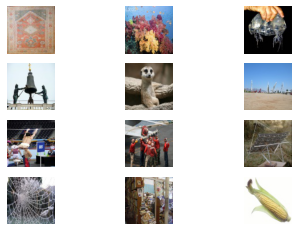

Query 13


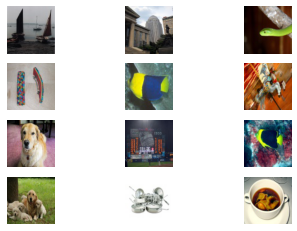

Query 14


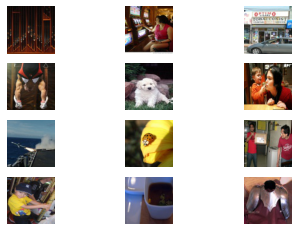

In [ ]:
## Re-define the network
model = ResNet(BasicBlock, [2, 1, 2, 1], args.num_classes).to(device) ##ResNet-14
model.layer3.register_forward_hook(get_activation('layer3'))

SimilarImages = getKNN(args, model, device, test_loader,layer_features)
SimilarImages = SimilarImages.cpu().numpy()

kernels = model.conv1.weight.detach()
kernels = (kernels - kernels.min()) / (kernels.max() - kernels.min())

plt.figure()
print("First layer 7x7 filters with randomly initialyzed network")
for i in range(0, 8):
    for j in range(0, 8):
        plt.subplot(8, 8, i*8 + j +1)
        plt.imshow(kernels[i*8 + j].squeeze().permute(1, 2, 0).cpu().numpy())
        plt.axis('off')
plt.show()
## First image in the subplot is the query, we show 11 most similar images according to learnt features
for i in range(0, 14):
    plt.figure()
    for j in range(0, SimilarImages.shape[1]):
        plt.subplot(4, 3, j+1)
        plt.imshow(test_loader.dataset.data[SimilarImages[examples_idx[i], j], ...])
        plt.axis('off')
    print("Query " + str(i+1) )
    plt.show()
